In [1]:
import numpy as np

import torch
from torch import nn
from torch import optim

import tqdm

import tkinter

from IPython.display import clear_output

/Users/binom/.anaconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append('..')

from samplers import mala, i_sir, ex2_mcmc

In [3]:
from cifar10_experiments.models import Generator, Discriminator

In [4]:
device = 'cpu'
lat_size=100

In [5]:
gen_cifar10 = Generator(lat_size)
gen_cifar10.to(device)

discr_cifar10 = Discriminator()
discr_cifar10.to(device)

prior_cifar10 = torch.distributions.MultivariateNormal(torch.zeros(lat_size).to(device), torch.eye(lat_size).to(device))

In [7]:
gen_cifar10.load_state_dict(torch.load('./weights/generator.pkl', map_location='cpu'))
discr_cifar10.load_state_dict(torch.load('./weights/discriminator.pkl', map_location='cpu'))
gen_cifar10.eval()
discr_cifar10.eval();

In [8]:
def get_energy_wgan(z):
    return (-discr_cifar10(gen_cifar10(z)).squeeze() - prior_cifar10.log_prob(z).squeeze())

def log_target_dens(x):
    """
    returns the value of a target density - mixture of the 3 gaussians 
    """
    x = torch.FloatTensor(x).to(device)
    return -get_energy_wgan(x).detach().cpu().numpy()

def grad_log_target_dens(x):
    """
    returns the gradient of log-density 
    """
    x = torch.FloatTensor(x).to(device)
    x.requires_grad_(True)
    external_grad = torch.ones(x.shape[0])
    (-get_energy_wgan(x)).backward(gradient=external_grad)
    return x.grad.data.detach().cpu().numpy()

In [9]:
log_target_dens(np.random.randn(2, lat_size))

array([-1717.3022, -1726.4563], dtype=float32)

In [10]:
grad_log_target_dens(np.random.randn(2, lat_size)).shape

(2, 100)

### Put parameters of the target density

In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

100%|█████████████████████████████████████████████| 9/9 [00:07<00:00,  1.15it/s]


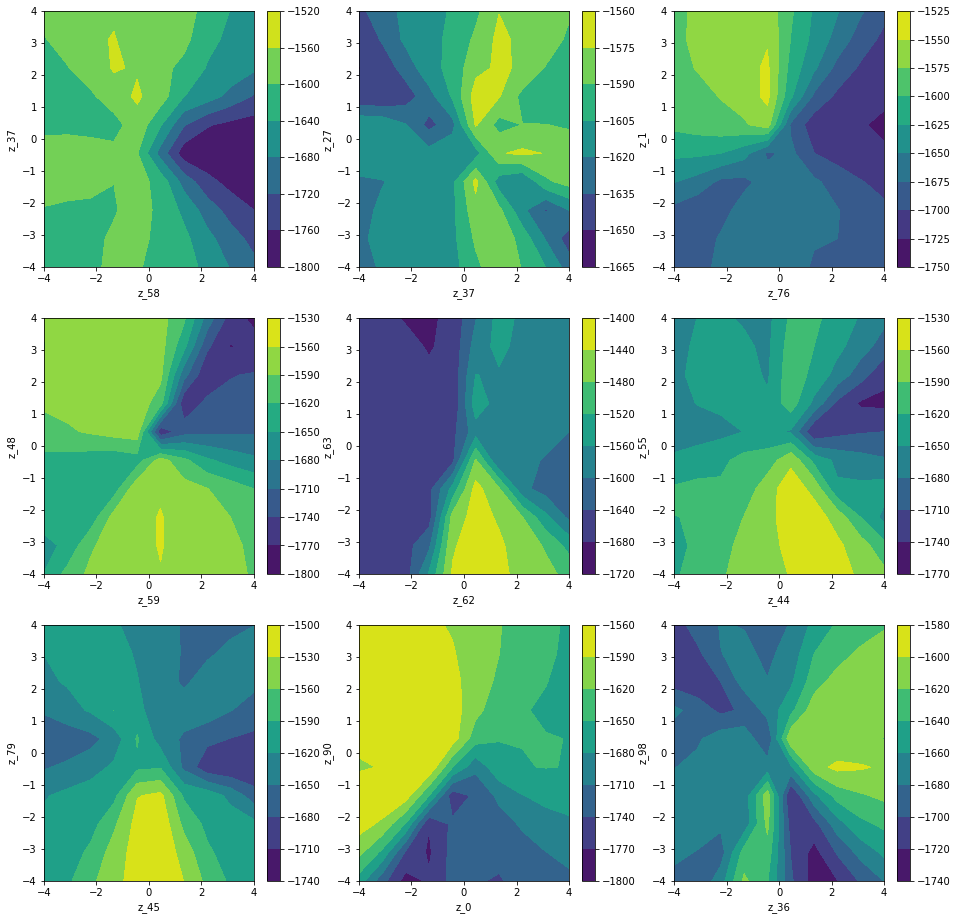

In [12]:
a = 2

plt.figure(figsize=(16, 16))

idxs = []
dens = []

for j in tqdm.tqdm(range(9)):
    idxs_perm = np.random.permutation(np.arange(lat_size))
    
    i1 = idxs_perm[0]
    i2 = idxs_perm[1]
    
    c1 = np.zeros(lat_size)
    c1[i1] = 1

    c2 = np.zeros(lat_size)
    c2[i2] = 1

    idxs.append((i1, i2))
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)
    points = np.zeros((X.shape[0],X.shape[1], 2),dtype=float)
    points[:, :, 0] = X
    points[:, :, 1] = Y

    points = points.reshape(-1, 2)

    batch_size = 128

    dens_vals = []
    for i in range(points.shape[0] // batch_size + (1 if points.shape[0] % batch_size else 0)):
        z = points[i * batch_size: (i + 1) * batch_size, 0:1] * c1[None, :] + points[i * batch_size: (i + 1) * batch_size, 1:2] * c2[None, :]
        dens_vals.append(log_target_dens(z))

    dens_vals = np.concatenate(dens_vals).reshape(N_pts, N_pts)
    
    dens.append(dens_vals)

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

In [21]:
N_traj = 10
N_steps = 100
N_particles = 10

sigma_isir = 1.0

def log_dens_isir(x,sigma):
    """
    compute log-density of a normal distributio nwith standard deviation sigma**2
    """
    return -np.sum(x**2, axis=1)/(2*sigma**2)

### sample i-sir
np.random.seed(42)
Samples_isir = np.zeros((N_traj, N_steps, lat_size), dtype = float)
x0 = np.random.randn(N_traj, lat_size)
x_cur = x0
energies_isir = []
for i in tqdm.tqdm(range(N_steps)):
    x_cur = i_sir(log_target_dens, log_dens_isir, x_cur, N_particles, sigma_isir)
    Samples_isir[:, i, :] = x_cur
    energies_isir.append(-log_target_dens(Samples_isir[:, i, :]))

100%|█████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 33.96it/s]


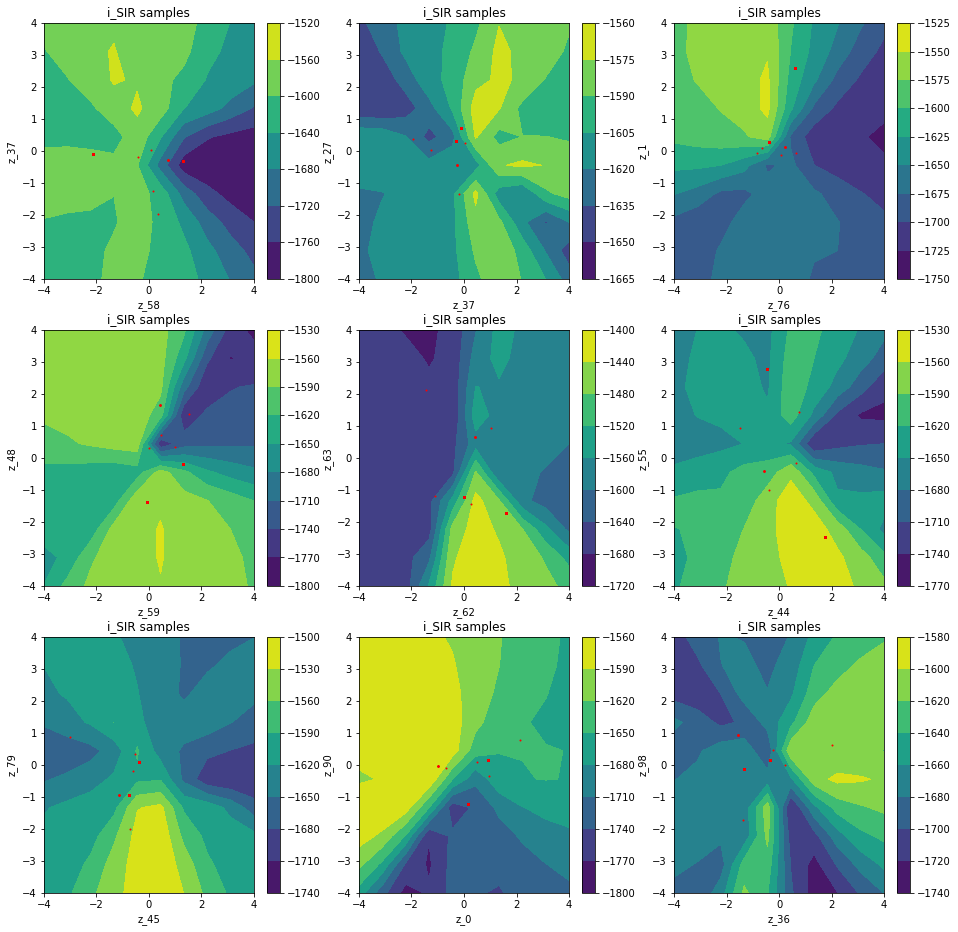

In [22]:
a = 2

plt.figure(figsize=(16, 16))

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.scatter(Samples_isir[0, :, i1],Samples_isir[0, :, i2], s=1, c='r')
    plt.title('i_SIR samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

In [34]:
gen_cifar10(torch.FloatTensor(Samples_isir[0, 0:1])).shape

torch.Size([1, 3, 32, 32])

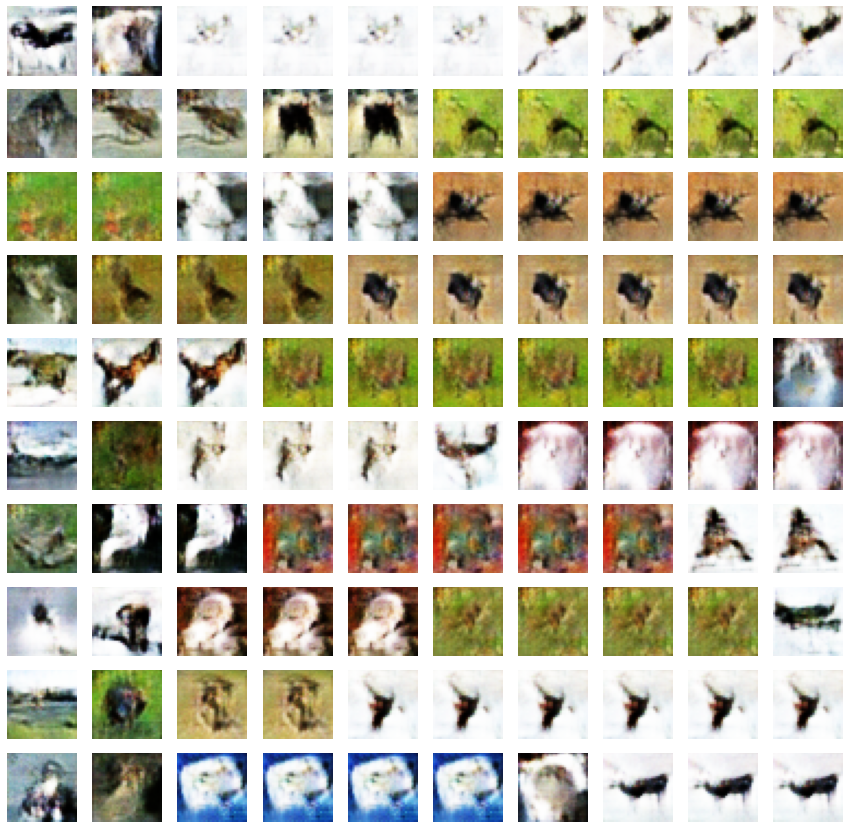

In [41]:
plt.figure(figsize=(15, 15))

for traj_i in range(10):
    for step_i in range(10):
        plt.subplot(10, 10, 10 * traj_i + step_i + 1)
        img = gen_cifar10(torch.FloatTensor(Samples_isir[traj_i, step_i * 10:step_i * 10 + 1]))[0].detach().cpu().numpy()
        img = (img + 1) / 2
        
        plt.axis('off')
        plt.imshow(img.transpose((1, 2, 0)))

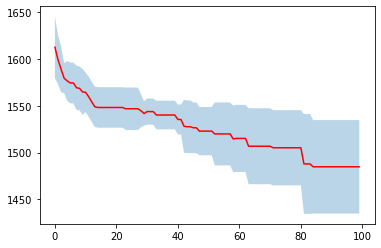

In [23]:
means = np.array([e.mean() for e in energies_isir])
stds = np.array([e.std() for e in energies_isir])

plt.plot(np.arange(N_steps), means, c='r')
plt.fill_between(np.arange(N_steps), means - stds, means + stds, alpha=0.3)

In [25]:
### sample mala
N_traj = 10
N_steps = 100

gamma = 5e-3
N_steps_mala = 3

np.random.seed(42)
Samples_mala = np.zeros((N_traj, N_steps, lat_size),dtype = float)
x0 = np.random.randn(N_traj, lat_size)
x_cur = x0
n_accepts = 0

energies_mala = []

def logp_mala(grad_log_target_dens, y,z,gamma):
    return -1/(4*gamma)*(np.sum((y - z - gamma*grad_log_target_dens(z))**2, axis=-1))

for i in tqdm.tqdm(range(N_steps)):
    x_cur = mala(log_target_dens, grad_log_target_dens, logp_mala, x_cur,gamma,N_steps_mala, n_accepts)
    Samples_mala[:, i, :] = x_cur
    energies_mala.append(-log_target_dens(Samples_mala[:, i, :]))
    
print("number accepts = ",n_accepts)

100%|█████████████████████████████████████████| 100/100 [04:58<00:00,  2.98s/it]

number accepts =  0


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 61.06it/s]


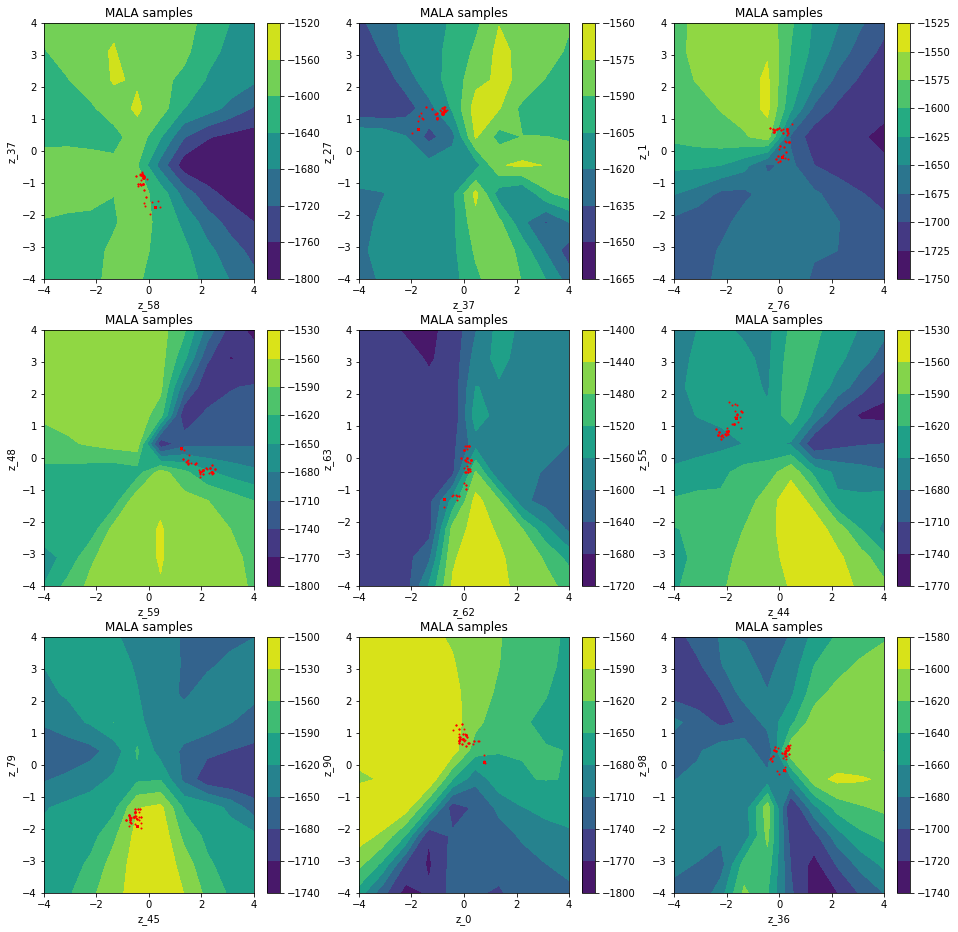

In [26]:
a = 2

plt.figure(figsize=(16, 16))

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.scatter(Samples_mala[0, :, i1],Samples_mala[0, :, i2], s=1, c='r')
    plt.title('MALA samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

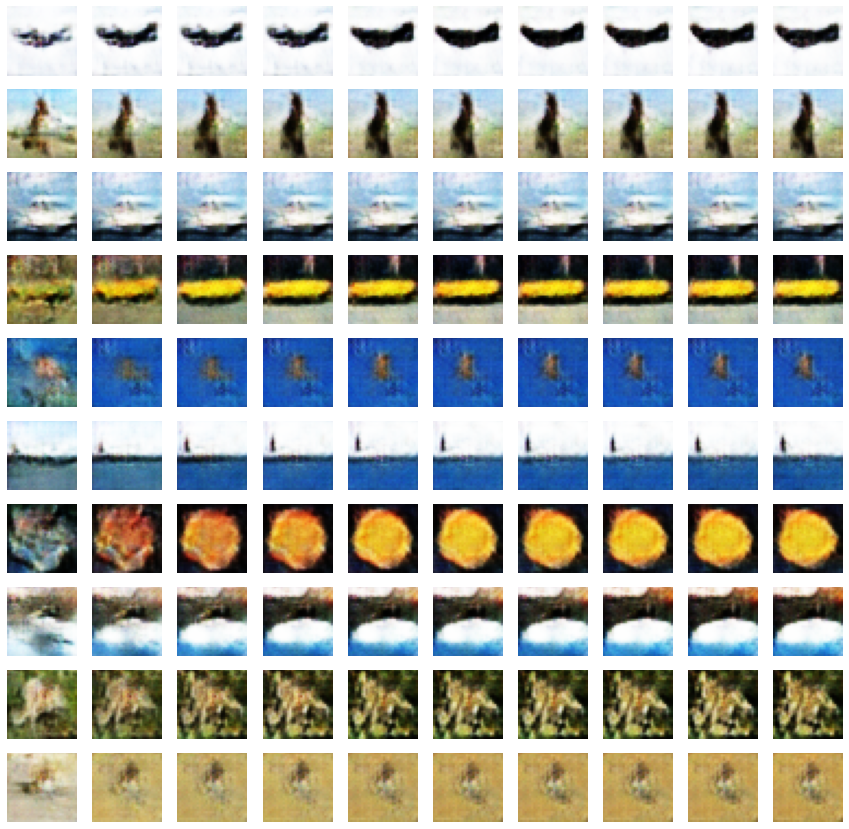

In [42]:
plt.figure(figsize=(15, 15))

for traj_i in range(10):
    for step_i in range(10):
        plt.subplot(10, 10, 10 * traj_i + step_i + 1)
        img = gen_cifar10(torch.FloatTensor(Samples_mala[traj_i, step_i * 10:step_i * 10 + 1]))[0].detach().cpu().numpy()
        img = (img + 1) / 2
        
        plt.axis('off')
        plt.imshow(img.transpose((1, 2, 0)))

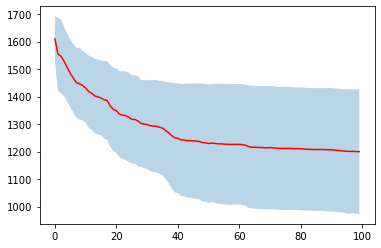

In [27]:
means = np.array([e.mean() for e in energies_mala])
stds = np.array([e.std() for e in energies_mala])

plt.plot(np.arange(N_steps), means, c='r')
plt.fill_between(np.arange(N_steps), means - stds, means + stds, alpha=0.3)

In [28]:
### sample ex2mcmc
N_traj = 10
N_steps = 100

gamma = 5e-3
N_steps_mala = 3

N_particles = 5

sigma_isir = 1.0

def log_dens_isir(x,sigma):
    """
    compute log-density of a normal distributio nwith standard deviation sigma**2
    """
    return -np.sum(x**2, axis=1)/(2*sigma**2)

def logp_mala(grad_log_target_dens, y,z,gamma):
    return -1/(4*gamma)*(np.sum((y - z - gamma*grad_log_target_dens(z))**2, axis=-1))



np.random.seed(42)

Samples_ex2 = np.zeros((N_traj, N_steps, lat_size),dtype = float)
x0 = np.random.randn(N_traj, lat_size)
x_cur = x0
n_accepts = 0

energies_ex2 = []

for i in tqdm.tqdm(range(N_steps)):
    x_cur = ex2_mcmc(log_target_dens, grad_log_target_dens, logp_mala, log_dens_isir, x_cur,N_particles,sigma_isir,gamma,N_steps_mala, n_accepts)
    Samples_ex2[:, i, :] = x_cur
    energies_ex2.append(-log_target_dens(Samples_ex2[:, i, :]))
print("number accepts = ", n_accepts)

100%|█████████████████████████████████████████| 100/100 [05:38<00:00,  3.39s/it]

number accepts =  0


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 35.13it/s]


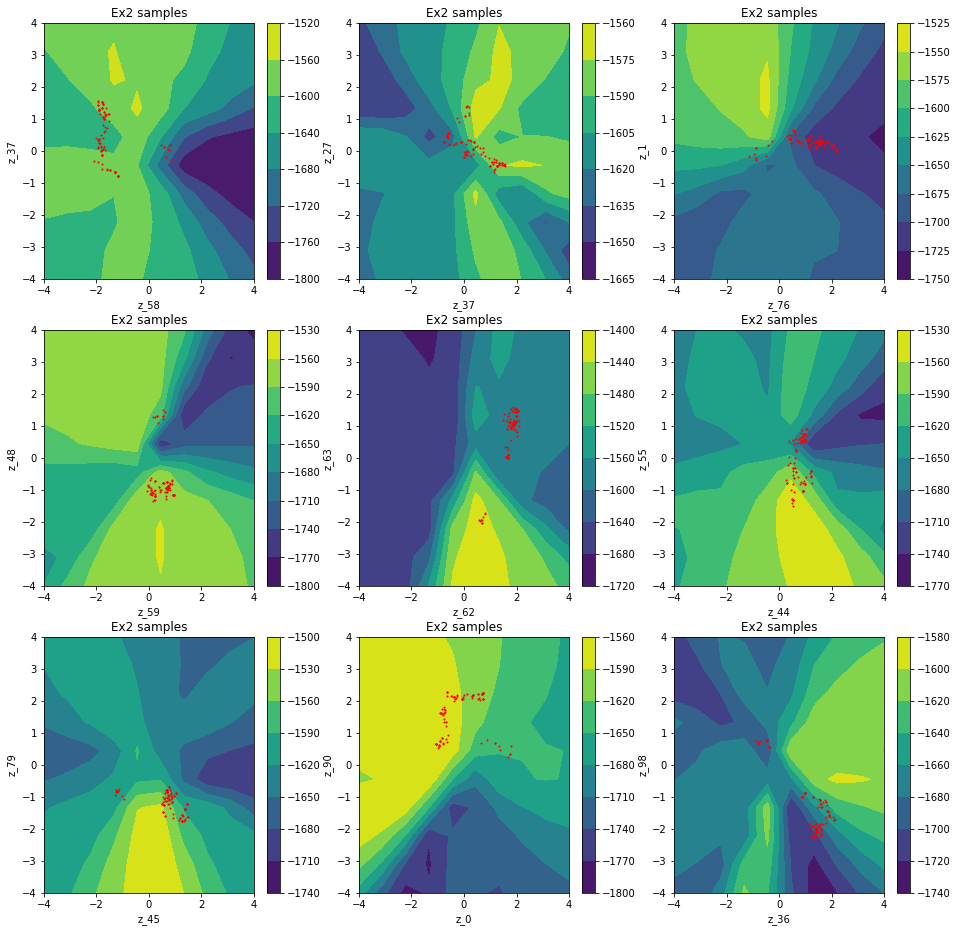

In [29]:
a = 2

plt.figure(figsize=(16, 16))

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.scatter(Samples_ex2[1, :, i1], Samples_ex2[1, :, i2], s=1, c='r')
    plt.title('Ex2 samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

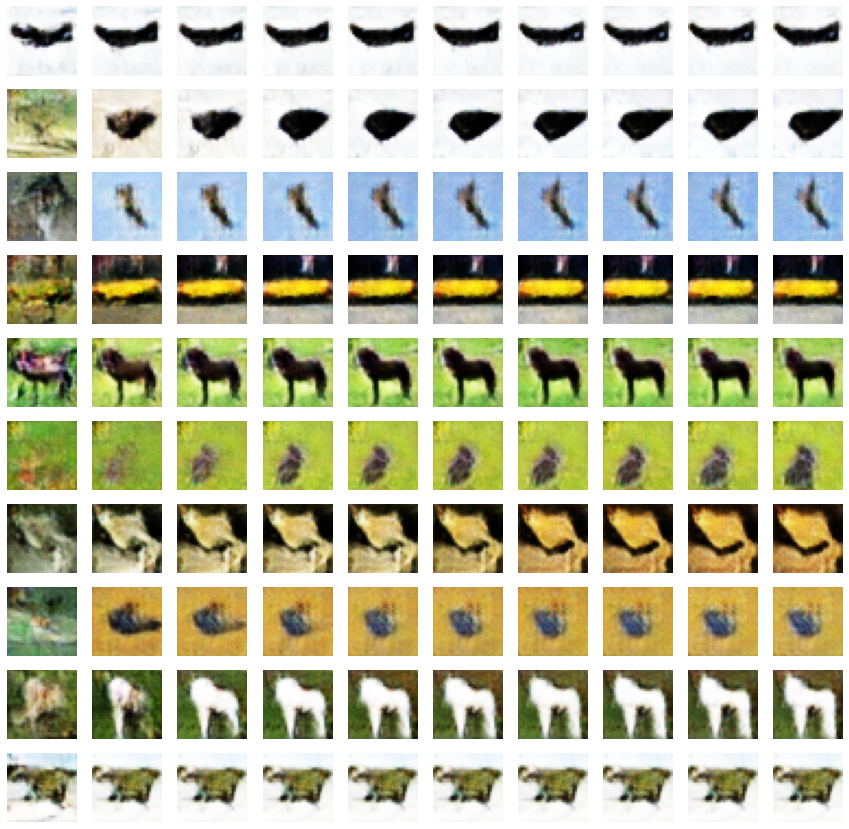

In [43]:
plt.figure(figsize=(15, 15))

for traj_i in range(10):
    for step_i in range(10):
        plt.subplot(10, 10, 10 * traj_i + step_i + 1)
        img = gen_cifar10(torch.FloatTensor(Samples_ex2[traj_i, step_i * 10:step_i * 10 + 1]))[0].detach().cpu().numpy()
        img = (img + 1) / 2
        
        plt.axis('off')
        plt.imshow(img.transpose((1, 2, 0)))

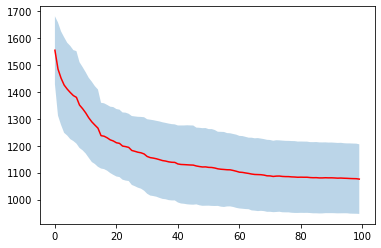

In [30]:
means = np.array([e.mean() for e in energies_ex2])
stds = np.array([e.std() for e in energies_ex2])

plt.plot(np.arange(N_steps), means, c='r')
plt.fill_between(np.arange(N_steps), means - stds, means + stds, alpha=0.3)

### Plot all 3 pictures together

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 61.94it/s]


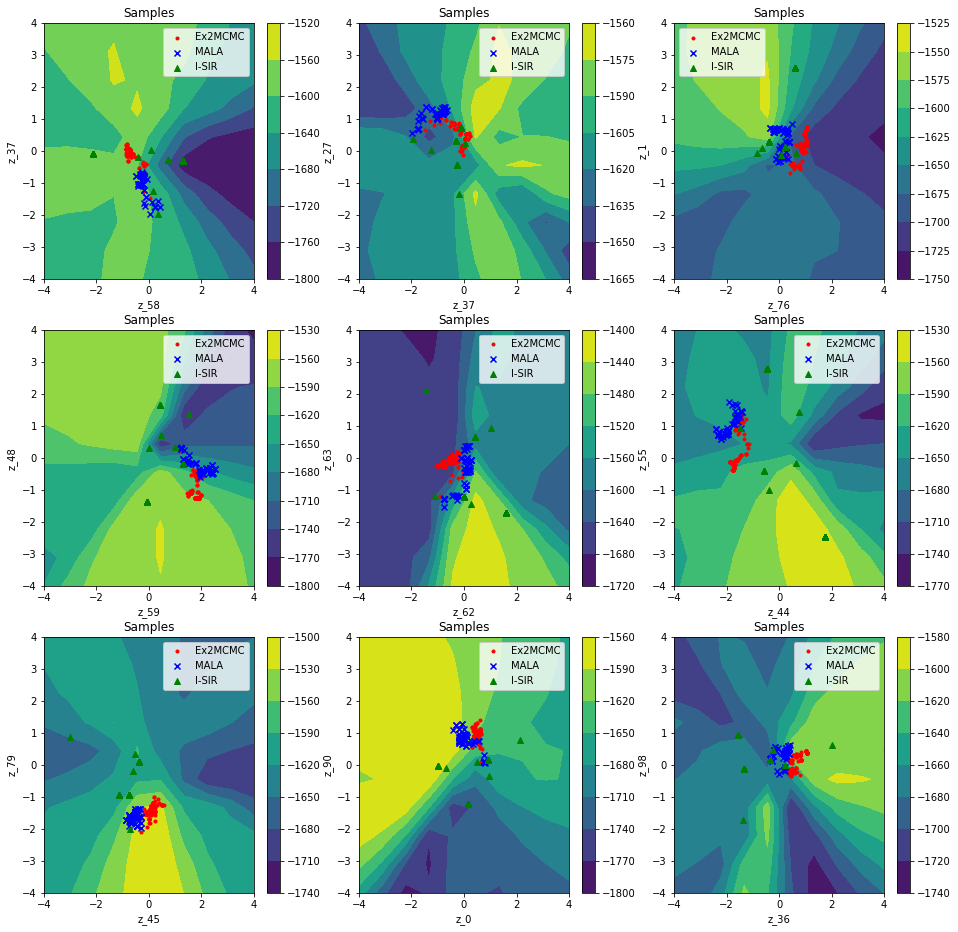

In [31]:
a = 2

plt.figure(figsize=(16, 16))

for j in tqdm.tqdm(range(9)):
    i1, i2 = idxs[j]
    
    N_pts = 10
    xlist = np.linspace(-2*a, 2*a, N_pts)
    ylist = np.linspace(-2*a, 2*a, N_pts)

    X, Y = np.meshgrid(xlist, ylist)

    dens_vals = dens[j]

    plt.subplot(3, 3, j+1)
    cp = plt.contourf(X, Y, dens_vals)
    plt.colorbar(cp) # Add a colorbar to a plot
    
    plt.scatter(Samples_ex2[0, :, i1], Samples_ex2[0, :, i2],  c='r', marker='.', label='Ex2MCMC') 
    plt.scatter(Samples_mala[0, :, i1], Samples_mala[0, :, i2], c='b', marker='x', label='MALA')
    plt.scatter(Samples_isir[0, :, i1], Samples_isir[0, :, i2], c='g', marker='^', label='I-SIR')
    
    plt.legend()
    
    plt.title('Samples')
    
    plt.xlabel(f'z_{i1}')
    plt.ylabel(f'z_{i2}')
    
plt.show()

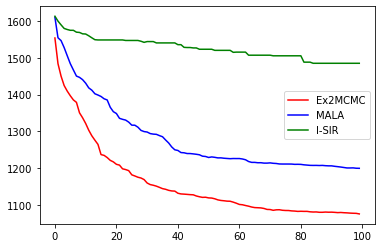

In [32]:
means = np.array([e.mean() for e in energies_ex2])
stds = np.array([e.std() for e in energies_ex2])

plt.plot(np.arange(N_steps), means, c='r', label='Ex2MCMC')
#plt.fill_between(np.arange(N_steps), means - stds, means + stds, color='r', alpha=0.2)


means = np.array([e.mean() for e in energies_mala])
stds = np.array([e.std() for e in energies_mala])

plt.plot(np.arange(N_steps), means, c='b', label='MALA')
#plt.fill_between(np.arange(N_steps), means - stds, means + stds, color='b', alpha=0.2)

means = np.array([e.mean() for e in energies_isir])
stds = np.array([e.std() for e in energies_isir])

plt.plot(np.arange(N_steps), means, c='g', label='I-SIR')
#plt.fill_between(np.arange(N_steps), means - stds, means + stds, color='g', alpha=0.2)



plt.legend()